# Identification of a nonlinear hardening model from cyclic data

In this demo, we use shear stress–strain data to identify a mixed nonlinear isotropic and kinematic hardening model with `jaxmat`.

```{admonition} Objectives
:class: important

In particular, this demo shows:

* How to define a generic mixed hardening plastic model
* How to simulate the stress response for a prescribed strain time history
* How to define and minimize a loss function against a time series
* How to split the material model between a trainable and a frozen part
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import jax

jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import equinox as eqx
import optimistix as optx
import optax
import jaxmat.materials as jm
from jaxmat.tensors import SymmetricTensor2
from jaxmat.utils import default_value, partition_by_node_names, print_eqx_fields

key = jax.random.PRNGKey(15071988)

## Defining a mixed hardening elastoplastic model

### General formulation

The material model considered here combines linear elasticity with a nonlinear hardening law. The Cauchy stress is given by $\bsig=\CC:(\beps-\bepsp)$. Hardening is described by the combination of a kinematic and isotropic mechanism. Both are described via a hardening potential $\psi_\text{h}(\balpha, p)$, expressed as function of a kinematic hardening strain $\balpha$ and the cumulated plastic strain $p$. Its derivatives provide the state laws for the corresponding kinematic and isotropic thermodynamic forces, namely:

```{math}
\begin{align*}
\bX(\balpha, p) &= \dfrac{\partial \psi_\text{h}}{\partial \balpha}(\balpha, p)\\
R(\balpha, p) &= \dfrac{\partial \psi_\text{h}}{\partial p}(\balpha, p)
\end{align*}
```

The plastic yield criterion is assumed to be of the following form:

```{math}
F(\bsig,\bX,R) = f(\bsig,\bX) - R - \sigma_0 \leq 0
```

where $\sigma_0$ is the initial yield stress.

The evolution equations for the internal state variables are thus given by:

```{math}
\begin{align*}
\dot{\bepsp} &= \dot{\lambda}\dfrac{\partial F}{\partial \bsig} = \dot{\lambda}\dfrac{\partial f}{\partial \bsig} \\
\dot{\balpha} &= -\dot{\lambda}\dfrac{\partial F}{\partial \bX} = -\dot{\lambda}\dfrac{\partial f}{\partial \bX} \\
\dot{p} &= -\dot{\lambda}\dfrac{\partial F}{\partial R} = \dot{\lambda}
\end{align*}
```

which are to be completed by the plastic consistency conditions $\dot{\lambda} F(\bsig,\bX,R) = 0$, $\dot{\lambda} \geq 0$ and $F(\bsig,\bX, R) \leq 0$.

This generic hardening behavior is implemented in the class `jaxmat.materials.GeneralHardening` which relies on an elastic model, a constant yield stress $(\sigma_0)$, a plastic surface and a combined hardening potential. The plastic surface extends `AbstractPlasticSurface` by implementing $f(\bsig,\bX)$ and also returning the plastic normal $\bn = \dfrac{\partial f}{\partial \bsig}$ and the hardening derivative $\partial_{\bX} f = \dfrac{\partial f}{\partial \bX}$. The combined hardening potential should provide the two methods `dalpha(alpha, p)` and `dp(alpha, p)`, returning respectively the two partial derivatives $\dfrac{\partial \psi_\text{h}}{\partial \balpha}$ and $\dfrac{\partial \psi_\text{h}}{\partial p}$.

The system of evolution equations is discretized in time using a backward-Euler fully implicit scheme and the resulting system of nonlinear equations is solved using a Newton-Raphson method.

### Decoupled kinematic/isotropic hardening

In the following, we particularize the behavior to decoupled hardening, assuming linear kinematic and nonlinear isotropic hardening, i.e.:

```{math}
\psi_\text{h}(\balpha, p) = \dfrac{1}{2}H\balpha:\balpha + \psi_\text{iso}(p)
```

so that:

```{math}
\begin{align*}
\bX(\balpha) &= H\balpha\\
R(p) &= \psi_\text{iso}'(p)
\end{align*}
```

We also assume the plastic criterion to take the following specific form:

```{math}
f(\bsig,\bX) - R - \sigma_0 = \|\bsig - \bX(\balpha)\|_\text{eq} - R(p) - \sigma_0
```

using the von Mises equivalent norm $\|\bsig\|_\text{eq} = \sqrt{\dfrac{3}{2}\bs:\bs}$ with $\bs=\dev(\bsig)$.

Introducing the normal $\bn(\bsig) = \dfrac{\partial f}{\partial \bsig}(\bsig)$ to the plastic surface, the evolution equations are thus simplified to:

```{math}
\begin{align*}
\dot{\bepsp} &= \dot{p}\bn(\bsig-\bX) \\
\dot{\balpha} &= \dot{\bepsp} \\
\dot{p}F(\bsig,\bX, R) &= 0, \: \dot{p} \geq 0, \: F(\bsig,\bX,R) \leq 0
\end{align*}
```

### Implementation

In [2]:
elasticity = jm.LinearElasticIsotropic(E=jnp.float64(200.0e3), nu=jnp.float64(0.25))


class PlasticSurface(jm.AbstractPlasticSurface):
    def __call__(self, sig, X):
        return jm.vonMises()(sig - X)

    def dX(self, sig, X):
        return jax.jacfwd(self.__call__, argnums=1)(sig, X)


plastic_surface = PlasticSurface()


class CombinedHardening(eqx.Module):
    isotropic: eqx.Module
    H: float = default_value(0.0)

    def dalpha(self, alpha, p):
        """Linear kinematic hardening rule"""
        return self.H * alpha

    def dp(self, alpha, p):
        """Nonlinear isotropic hardening rule"""
        return self.isotropic(p)


hardening = CombinedHardening(
    isotropic=jm.VoceHardening(sig0=0.0, sigu=200.0, b=50.0), H=1e3
)

material = jm.GeneralHardening(
    elastic_model=elasticity,
    yield_stress=100.0,
    plastic_surface=plastic_surface,
    combined_hardening=hardening,
)

/tmp/ipykernel_1202761/3192898755.py:32: UserWarning: A JAX array is being set as static! This can result in unexpected behavior and is usually a mistake to do.
  material = jm.GeneralHardening(


## Reference cyclic shear strain data

We begin by loading the reference cyclic shear strain data representing repeated loading–unloading cycles of increasing strain amplitude.

The reference data has been generated with the previous behavior using the following values:
- elasticity $E=200\text{ GPa}$, $\nu=0.25$
- yield stress $\sigma_0=200\text{ MPa}$
- Voce isotropic hardening $R(p) = (\sigma_\text{u}-\sigma_0)(1-\exp(-bp))$ with $\sigma_\text{u}=600\text{ MPa}$ and $b=200$.
- kinematic hardening modulus $H=5\text{ GPa}$

To simulate experimental uncertainty, we add a small Gaussian noise to the measured stresses. This will allow us to test the robustness of the identification procedure.

The following figure shows the clean and noisy cyclic data used for training.

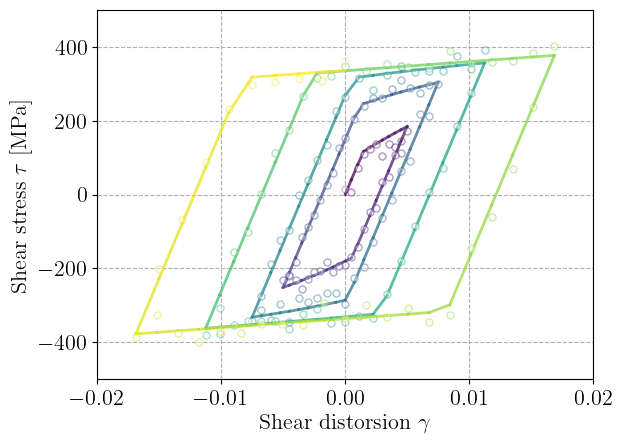

In [3]:
data = np.loadtxt("mixed_hardening_data.csv", delimiter=",", skiprows=1)
gamma_train = data[:, 0]
tau_train = data[:, 1]

noise_level = 5e-2
tau_noise = (
    tau_train + jax.random.normal(key, tau_train.shape) * max(tau_train) * noise_level
)

cmap = plt.get_cmap("viridis")
Ndata = len(gamma_train) - 1
colors = cmap(jnp.linspace(0, 1, Ndata))
for i in range(Ndata):
    plt.plot(
        gamma_train[i : i + 2], tau_train[i : i + 2], "-", color=colors[i], alpha=0.75
    )
    plt.plot(
        gamma_train[i : i + 2],
        tau_noise[i : i + 2],
        "o",
        color=colors[i],
        alpha=0.25,
        markerfacecolor="white",
        markersize=5,
    )
plt.xlabel(r"Shear distorsion $\gamma$")
plt.ylabel(r"Shear stress $\tau$ [MPa]")
plt.xlim(-0.02, 0.02)
plt.ylim(-500.0, 500.0)
plt.show()

For a given material model, we define the function `compute_evolution` allowing to compute the cyclic stress response as a function of a given shear strain time series. Starting from a initial state, we use `jax.lax.scan` to replace Python `for` loops and output the computed shear stress in the $x,y$ direction.

In [4]:
@eqx.filter_jit
def compute_evolution(material, gamma_list, dt=0.0):
    # Initial material state
    state0 = material.init_state()

    def step(state, gamma):
        # Build symmetric strain tensor
        new_eps = jnp.array([[0, gamma / 2, 0], [gamma / 2, 0, 0], [0, 0, 0]])

        # Create tensor object (assuming this is JAX-compatible)
        new_eps = SymmetricTensor2(tensor=new_eps)

        # Update material response
        new_stress, new_state = material.constitutive_update(new_eps, state, dt)

        # Extract tau_12 (shear stress)
        tau_12 = new_stress[0, 1]

        return new_state, tau_12

    # Use lax.scan to loop over gamma_list efficiently
    _, tau = jax.lax.scan(step, state0, gamma_list)

    return tau

## Initial model

We simulate the material response to the prescribed cyclic shear strain history by repeatedly integrating the constitutive equations. The resulting stress signal is compared to the target data.

The plot below shows the initial model response (before calibration) against the noisy reference data. At this stage, the predicted hysteresis loops do not match with that observed in the target data.

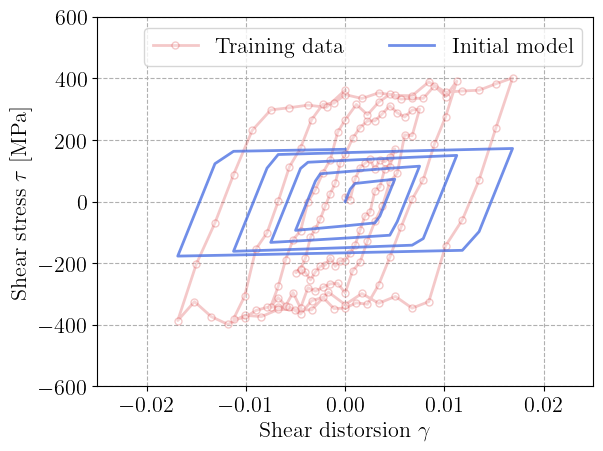

In [10]:
tau = compute_evolution(material, gamma_train)

plt.figure()
plt.plot(
    gamma_train,
    tau_noise,
    "-oC3",
    alpha=0.25,
    markerfacecolor="white",
    markersize=5,
    label="Training data",
)
plt.plot(gamma_train, tau, "-", color="royalblue", alpha=0.75, label="Initial model")
plt.xlabel(r"Shear distorsion $\gamma$")
plt.ylabel(r"Shear stress $\tau$ [MPa]")
plt.xlim(-0.025, 0.025)
plt.ylim(-600.0, 600.0)
plt.legend(ncol=2)
plt.show()

## Defining and minimizing the loss function

The identification problem is formulated as the minimization of a loss function measuring the discrepancy between the predicted and observed shear stresses over the full loading history. We use the mean-squared error (MSE) as a standard choice:

$$
\mathcal{L}(\btheta) = \dfrac{1}{M}\sum_{k=1}^M (\hat\tau^{(k)}(\btheta) - \tau^\text{data,(k)})^2
$$
where $\hat\tau^{(k)}(\btheta)$ denotes the model-predicted shear stress at time step $k$ and $ \tau^\text{data,(k)}$ the corresponding measured value.

```{important}
Importantly, the model-predicted stresses $\hat\tau^{(k)}(\btheta)$ are not independent for each time step $k$. They are obtained sequentially by integrating the constitutive equations along the prescribed strain path, via `compute_evolution`. Each step depends on the current state of internal variables, which in turn evolves according to the entire previous loading history.
```

To provide fine-grained control of the optimization process, we rely on the `optimistix.OptaxMinimiser` interface and employ the Adam optimizer. This setup allows transparent use of differentiable JAX functions within the training loop while leveraging `optax`'s flexible chaining of transformations.

Because the model involves variables with very different physical units (e.g. stresses in MPa, strains of order $10^{-3}$), we include a parameter-block RMS scaling (`optax.scale_by_param_block_rms`) step. This operation automatically normalizes gradient magnitudes across parameter groups, effectively preconditioning the optimization. It enables stable training while keeping all parameters expressed in interpretable physical units.

The overall optimizer is built using `optax.chain`, where each transformation acts sequentially on the gradient:

In [6]:
@eqx.filter_jit
def loss(trainable, args):
    static, tau_data = args
    if static is None:
        material_ = trainable
    else:
        material_ = eqx.combine(trainable, static)

    tau_hat = compute_evolution(material_, gamma_train)
    loss_ = optax.l2_loss(tau_hat, tau_data)
    return loss_.mean(), tau_hat


learning_rate = 1e-1
optimizer = optax.chain(
    optax.scale_by_adam(),
    optax.scale_by_param_block_rms(),
    optax.scale(-learning_rate),
)

solver = optx.OptaxMinimiser(
    optimizer,
    rtol=1e-6,
    atol=1e-6,
    # verbose=frozenset({"loss", "step_size"}),
)

Once the optimizer is defined, we partition the material model into `trainable` and `static` components using the `jaxmat.utils.partition_by_node_names` function. The latter allows to split an `equinox` module in two sets by providing a list of field attribute names.  Here, the whole elastic model is fixed as well as the `sig0` field of the Voce isotropic hardening as the initial yield stress is already stored as a separate attribute. The remaining parameters stored in `trainable` are then optimized when training against the cyclic stress data.

During the minimization, the constitutive model is evaluated sequentially at each loading increment to compute the predicted stresses, and the loss is differentiated with respect to the trainable parameters. The keyword argument `options={"jac": "bwd"}` specifies that backward-mode automatic differentiation (reverse-mode AD) is used to compute the Jacobian–vector products required by the optimizer.
This choice is well suited here because we optimize a scalar-valued loss function.

After training, the final trained model is reconstructed by combining the trained part with the static part using `eqx.combine`.

In [7]:
trainable, static = partition_by_node_names(
    material, ["elastic_model", "combined_hardening.isotropic.sig0"]
)


max_steps = 1000
sol = optx.minimise(
    loss,
    solver,
    trainable,
    args=(static, tau_noise),
    has_aux=True,
    throw=False,
    max_steps=max_steps,
    options={"jac": "bwd"},
)
trained_params = sol.value
tau_hat = sol.aux
if static is None:
    trained_material = trained_params
else:
    trained_material = eqx.combine(trained_params, static)

## Results

The next figure compares the predicted and experimental stress–strain curves. The trained model captures both the isotropic hardening (loop expansion) and the kinematic hardening (loop translation) effects.

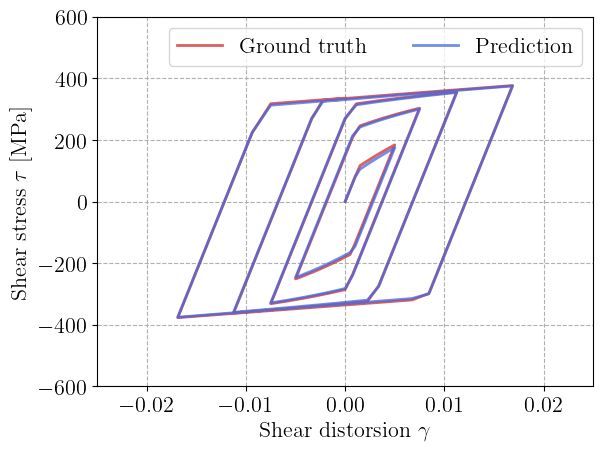

In [8]:
plt.figure()
plt.plot(gamma_train, tau_train, "-C3", alpha=0.75, label="Ground truth")
plt.plot(gamma_train, tau_hat, "-", color="royalblue", alpha=0.75, label="Prediction")
plt.xlabel(r"Shear distorsion $\gamma$")
plt.ylabel(r"Shear stress $\tau$ [MPa]")
plt.xlim(-0.025, 0.025)
plt.ylim(-600.0, 600.0)
plt.legend(ncol=2)
plt.show()

After convergence, we print the calibrated model parameters to verify their physical consistency. First, we can observe that the Young modulus, Poisson ratio and initial Voce yield stress remained the same since they have been considered frozen parameters. Second, we can see that the hardening rate parameter $b$ and kinematic hardening modulus $H$ have been correctly identified. Regarding the yield stress, the final yield stress is here `sig0+sigu` which is approximately $595 \text{ MPa}$, very close to the ground truth value of $600 \text{ MPa}$. There is a small discrepancy for the initial yield stress $\sigma_0$ which has been identified to be $172 \text{ MPa}$ instead of $200 \text{ MPa}$, probably due to the amount of noise and the lack of enough data in the initial yielding regime.

In [9]:
print_eqx_fields(
    trained_material, fields=["elastic_model", "yield_stress", "combined_hardening"]
)

GeneralHardening:
  elastic_model:
    LinearElasticIsotropic:
      E = 200000.0
      nu = 0.25
  yield_stress = 172.51551752965133
  combined_hardening:
    CombinedHardening:
      isotropic:
        VoceHardening:
          sig0 = 0.0
          sigu = 421.9090071164025
          b = 200.25649039512103
      H = 5311.534540795526


Overall, this workflow demonstrates how `jaxmat`, in combination with `equinox`, `optax`, and `optimistix`, provides a fully differentiable framework for constitutive parameter identification from cyclic mechanical tests.

Thanks to automatic differentiation (AD), all sensitivities — including those passing through the nonlinear implicit return-mapping solver at each time step — are computed exactly and efficiently. This allows gradients to propagate seamlessly through both the material state updates and the time integration loop, without any manual derivation of tangent operators.